# Cell level classifiers using Chrometric features

In [1]:
import importlib 
import util, models, training, eval

importlib.reload(util)
importlib.reload(models)
importlib.reload(training)
importlib.reload(eval)

<module 'eval' from '/home/unix/hschluet/projects/pt-pbmc/eval.py'>

In [2]:
from data import PlateDataset
from util import torch_random_choice
from models import MultiFeatClassifier, FeatClassifier
from training import train_model

import torch
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T 
import seaborn as sns
from sklearn.preprocessing import StandardScaler


device = 'cuda:1'

In [3]:
data = PlateDataset([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], load_chrometrics=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:50<00:00,  3.16s/it]


In [4]:
data.info

,plate,well,series,cell,patient,time,qc,group
0,1,A02,0,25,H01,0,True,healthy
1,1,A02,0,30,H01,0,True,healthy
2,1,A02,0,37,H01,0,True,healthy
3,1,A02,0,43,H01,0,True,healthy
4,1,A02,0,44,H01,0,True,healthy
...,...,...,...,...,...,...,...,...
1093961,16,H12,9,565,H15,0,True,healthy
1093962,16,H12,9,569,H15,0,True,healthy
1093963,16,H12,9,570,H15,0,True,healthy
1093964,16,H12,9,572,H15,0,True,healthy


In [5]:
data.imgs.shape

torch.Size([1093966, 1, 32, 32])

In [ ]:
chrometrics = data.chrometrics.values
use_cols = ~(np.isnan(chrometrics).any(axis=0) | np.isinf(chrometrics).any(axis=0))
chrometrics = StandardScaler().fit_transform(chrometrics[:, use_cols])
chrometrics = torch.from_numpy(chrometrics).float()
chrometrics.shape

torch.Size([1093966, 182])

## Classification cancer T1 and healthy

In [7]:
use_plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
cdf = data.info[data.info['plate'].isin(use_plates)].groupby(
    ['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H09', 'H10',
       'H13', 'H15', 'H16', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23',
       'H24', 'H25', 'H26', 'H29', 'H30', 'H31', 'H32', 'H33', 'H36',
       'H37', 'H39', 'H40', 'H43', 'H45', 'H47', 'H48', 'H49', 'P102',
       'P103', 'P104', 'P105', 'P106', 'P107', 'P109', 'P11', 'P110',
       'P111', 'P112', 'P113', 'P114', 'P115', 'P116', 'P117', 'P118',
       'P119', 'P120', 'P121', 'P123', 'P124', 'P125', 'P126', 'P127',
       'P128', 'P129', 'P13', 'P130', 'P131', 'P132', 'P134', 'P135',
       'P136', 'P137', 'P138', 'P139', 'P14', 'P140', 'P142', 'P143',
       'P144', 'P145', 'P146', 'P147', 'P148', 'P149', 'P15', 'P150',
       'P151', 'P152', 'P154', 'P155', 'P156', 'P158', 'P159', 'P16',
       'P160', 'P161', 'P162', 'P163', 'P164', 'P165', 'P166', 'P167',
       'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P27', 'P28', 'P29', 'P30', 'P32', 'P33', 'P34', 'P35', 'P37',
       'P38', 'P

In [8]:
data.info.groupby(['group'])['patient'].unique().map(len)

group
CNS-Ependymoma               7
CNS-Glioma                  17
CNS-Medulloblastoma          7
CNS-Meningioma              19
CNS-other                   12
Chordoma/Chondrosarcoma     21
H&N cancer                  37
Lymphoma                     7
Sarcoma-Ewing                8
Sarcoma-Neuroblastoma        2
Sarcoma-Rhabdomyosarcoma     4
Sarcoma-other                3
healthy                     35
Name: patient, dtype: int64

In [9]:
use_plates = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


def healthy_vs_cancer_bagloader(bag_size=50, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = chrometrics[use_idx].to(device)
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = data.info.groupby(['time'])['patient'].unique().map(lambda x: x[np.isin(x, use_patients)])
  pat_healthy = pat_groups[0]
  pat_cancer = pat_groups[1]
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)

  pat_min = min(len(pat_healthy), len(pat_cancer))
  while True:
    xs = []
    labels = []
    for lab, pats in zip([0, 1], [pat_cancer, pat_healthy]):
      sub = np.random.choice(pats, size=pat_min, replace=False)
      for pat in sub:
        xs.append(use_data[torch_random_choice(pat_lut[pat], size=bag_size)])
        labels.append(lab * torch.ones(bag_size))
    
    labels = torch.cat(labels).float().to(device) 
    xs = torch.cat(xs).float()
    # shuffle indices
    rand_idx = torch.randperm(len(xs))
    for left in range(0, bag_size * 2 * pat_min, bag_size):
      yield xs[rand_idx[left:left+bag_size]], labels[rand_idx[left:left+bag_size]]


def test_healthy_vs_cancer_bagloader(bag_size=100, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = chrometrics[use_idx].to(device)
  use_imgs = transform(data.imgs[use_idx].to(device))
  
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any():
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    idx = torch_random_choice(pat_idx, size=bag_size)
    xs = use_data[idx]
    label = 1 if pat[0] == 'H' else 0
    yield xs.float(), use_imgs[idx].float(), torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer'

In [10]:
def eval_model(name, loader):
    model = FeatClassifier(input_dim=182)
    model = model.to(device)
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    model.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    for i, (z, bag, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, _ = model(z.to(device))
        bag_ids.extend([i] * 100)
        bag_pats.extend([pat] * 100)
        bag_groups.extend([group] * 100)
        bag_labs.extend([lab.item()] * 100)
        bag_pred.extend(pred.cpu().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    return df, bag_zs, bags

In [11]:
xs, labs = next(healthy_vs_cancer_bagloader())
labs

tensor([0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:1')

In [12]:
xs

tensor([[ 3.2588e-01,  6.6338e-01, -4.2397e-01,  ..., -4.8327e-03,
         -1.0737e-02, -1.1194e-03],
        [-2.8486e-01, -9.4008e-01,  8.9459e-01,  ..., -4.8339e-03,
         -1.0889e-02, -1.1148e-03],
        [-1.5063e+00, -2.3817e-02, -1.9254e+00,  ..., -2.9417e-03,
          6.0472e-02, -3.0833e-03],
        ...,
        [-2.7278e+00, -1.6273e+00, -2.1167e+00,  ..., -4.8116e-03,
         -5.6461e-03, -1.0809e-03],
        [-8.9560e-01, -2.5288e-01, -9.1641e-01,  ..., -4.8268e-03,
         -9.3420e-03, -1.1320e-03],
        [ 2.1581e+00,  1.5796e+00,  5.2397e-01,  ..., -4.8341e-03,
         -1.1019e-02, -1.1133e-03]], device='cuda:1')

### Big model

  0%|                                                                                                                                                                                      | 0/100000 [00:00<?, ?it/s]

iter: 99999; train loss: 0.41101244; train error: 0.20000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:30<00:00, 474.42it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_by_cell_chrometrics_model.pt


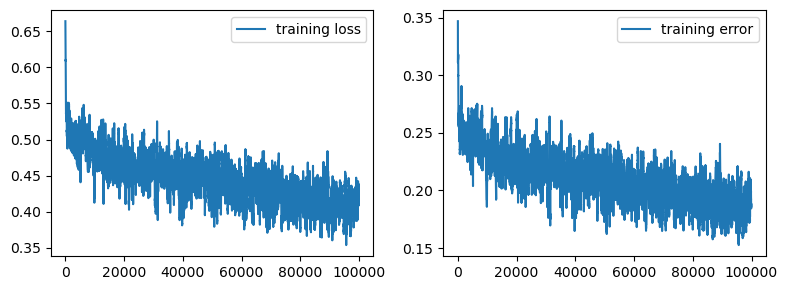

In [13]:
name = '1_16_t01_healthy_cancer_by_cell_chrometrics'
train_loader = healthy_vs_cancer_bagloader()
model = FeatClassifier(input_dim=182)
df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.0001, device=device, fname=name, plot=False, 
                 save_model=True, seed=12341)

w = 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
ax1.legend()
ax2.legend()
fig.tight_layout()
fig.show()

In [14]:
dfs = []
bag_zs = []
imgs = []
for plate in tqdm(use_plates):
  df, zs, b = eval_model('1_16_t01_healthy_cancer_by_cell_chrometrics', 
                         test_healthy_vs_cancer_bagloader(use_plates=[plate]))
  df['plate'] = plate
  dfs.append(df)
  bag_zs.append(zs)
  imgs.append(b)

res_df = pd.concat(dfs, ignore_index=True)
bag_zs = np.concatenate(bag_zs)
imgs = np.concatenate(imgs)
res_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.39it/s]


,lab,pred,i,pat,group,plate
0,1,1.0,0,H01,healthy,1
1,1,1.0,0,H01,healthy,1
2,1,0.0,0,H01,healthy,1
3,1,0.0,0,H01,healthy,1
4,1,1.0,0,H01,healthy,1
...,...,...,...,...,...,...
20195,0,0.0,11,P74,cancer,16
20196,0,0.0,11,P74,cancer,16
20197,0,1.0,11,P74,cancer,16
20198,0,0.0,11,P74,cancer,16


In [15]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df

,plate,pat,group,pred,counts
0,1,H01,healthy,1.0,81
1,1,H01,healthy,0.0,19
2,1,H02,healthy,1.0,95
3,1,H02,healthy,0.0,5
4,1,H03,healthy,1.0,95
...,...,...,...,...,...
385,16,P45,cancer,1.0,29
386,16,P61,cancer,1.0,52
387,16,P61,cancer,0.0,48
388,16,P74,cancer,0.0,79


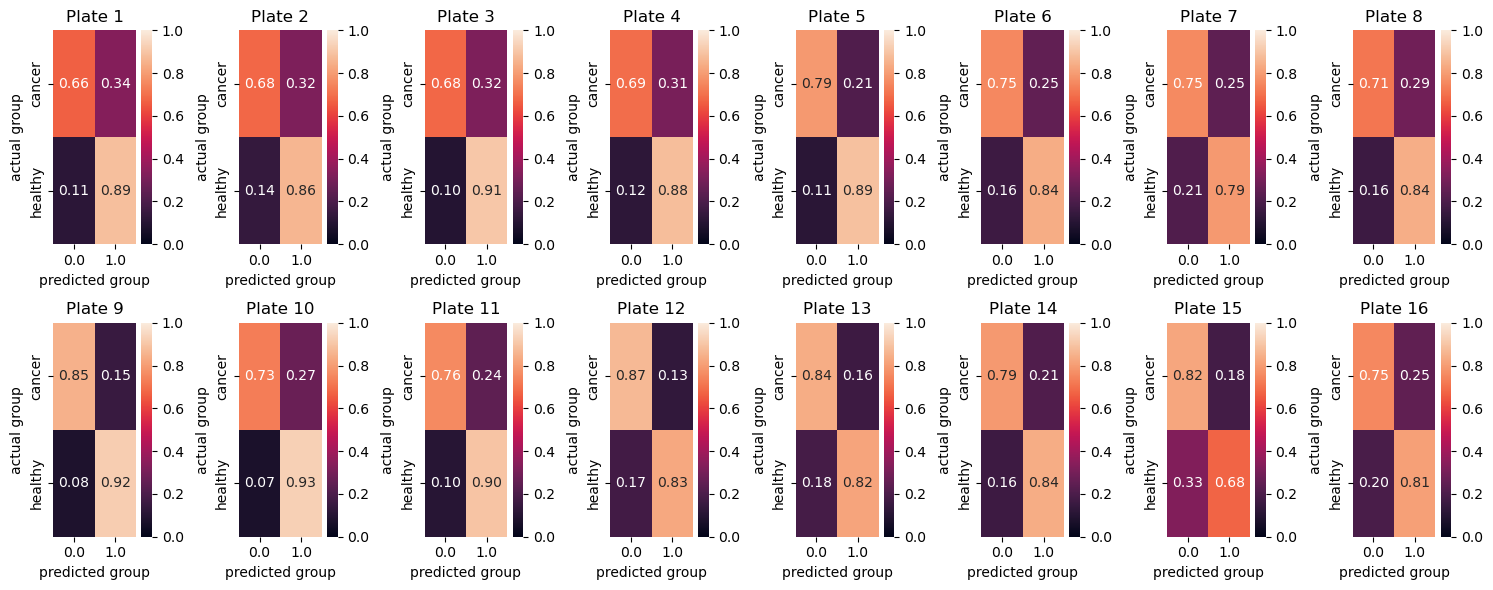

In [16]:
fig, axs = plt.subplots(2, 8, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

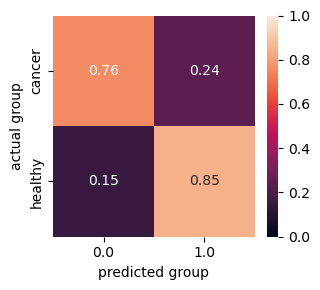

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

### Leave out one plate

iter: 14200; train loss: 0.61407983; train error: 0.31999999:  14%|███████████████▏                                                                                           | 14181/100000 [00:34<02:59, 478.95it/s]

iter: 99999; train loss: 0.26558653; train error: 0.08000004: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:25<00:00, 485.79it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_1_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.44682461; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:30<00:00, 475.32it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_2_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.32374606; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:28<00:00, 480.38it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_3_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.37635520; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:29<00:00, 476.23it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_4_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.29639927; train error: 0.14000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:24<00:00, 488.17it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_5_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.52647799; train error: 0.25999999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:23<00:00, 491.14it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_6_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.39756632; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:30<00:00, 476.14it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_7_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.53878576; train error: 0.31999999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:29<00:00, 477.12it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_8_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.42283049; train error: 0.20000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:24<00:00, 488.83it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_9_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.36281234; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:25<00:00, 486.50it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_10_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.43428618; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:28<00:00, 478.84it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_11_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.51695508; train error: 0.34000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:34<00:00, 465.99it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_12_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.42947733; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:32<00:00, 470.28it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_13_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.43931037; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:30<00:00, 474.71it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_14_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.47541353; train error: 0.30000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:27<00:00, 481.64it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_15_by_cell_chrometrics_model.pt


iter: 99999; train loss: 0.36322525; train error: 0.20000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:32<00:00, 470.63it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_16_by_cell_chrometrics_model.pt


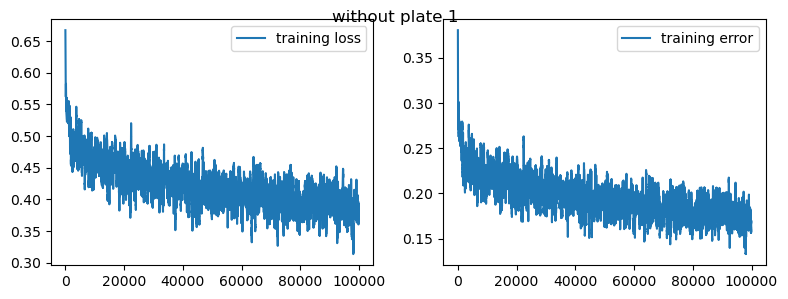

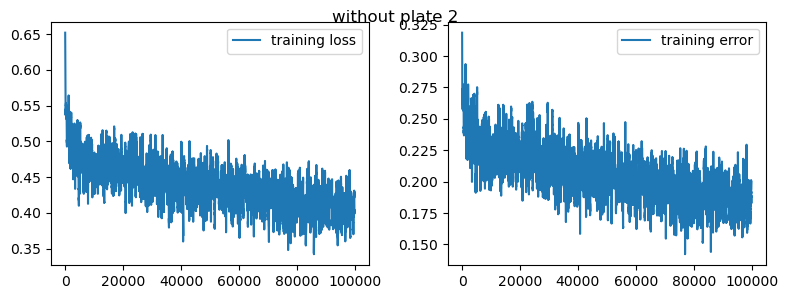

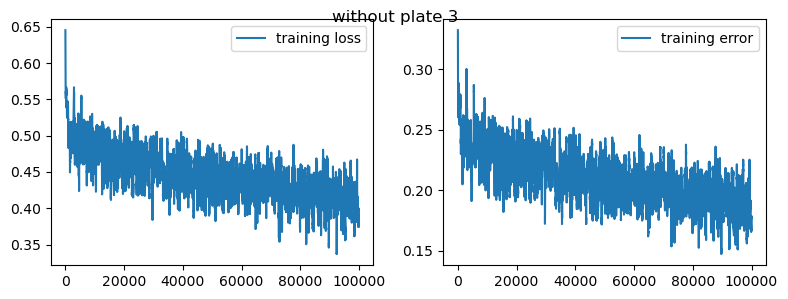

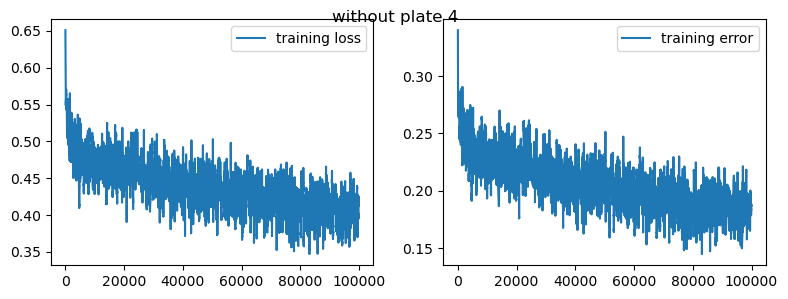

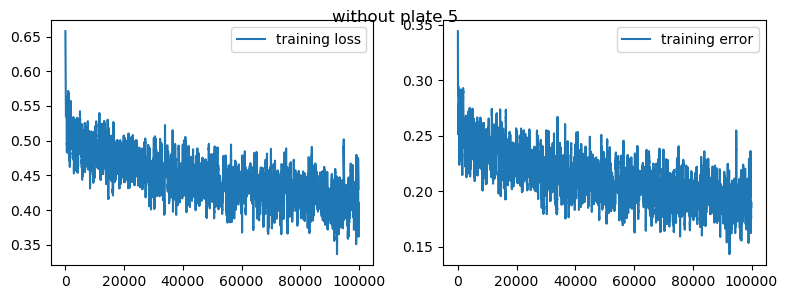

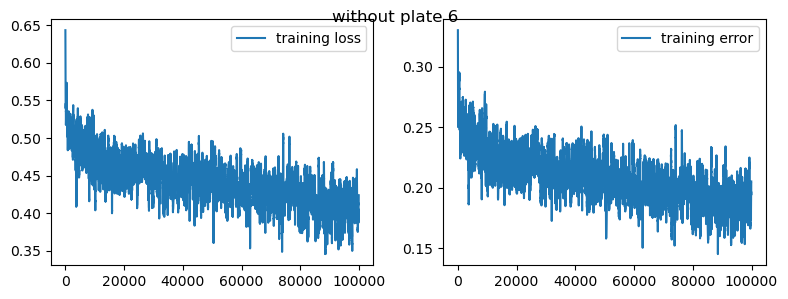

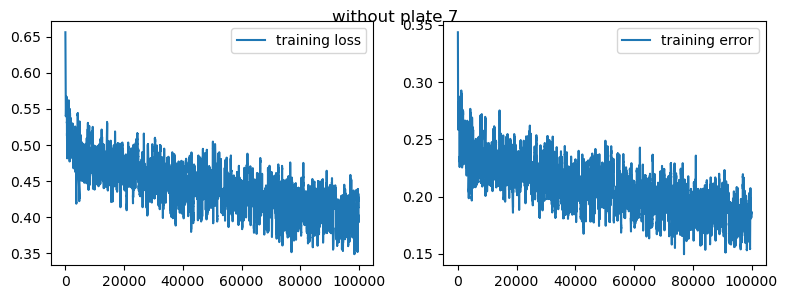

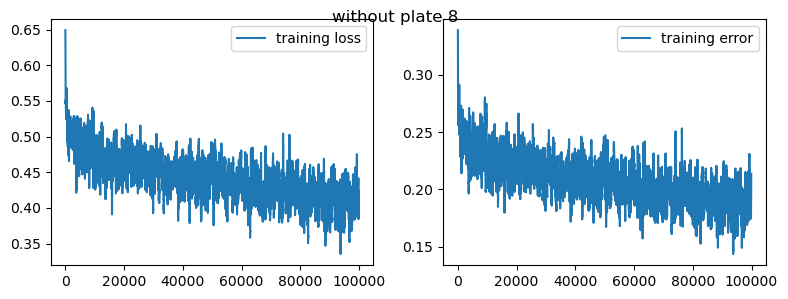

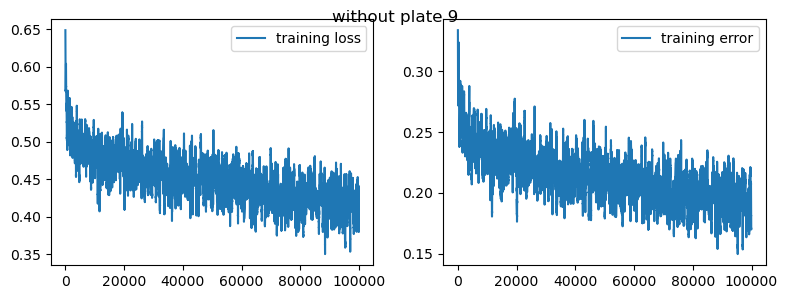

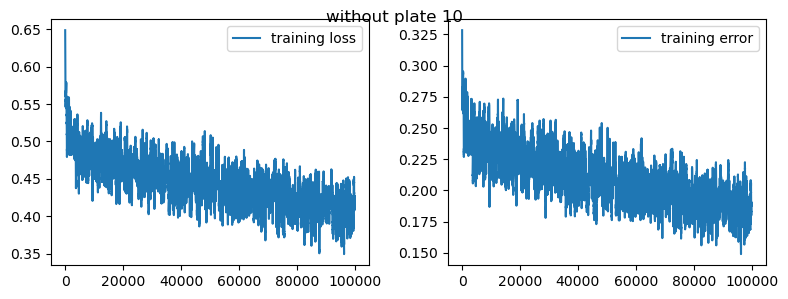

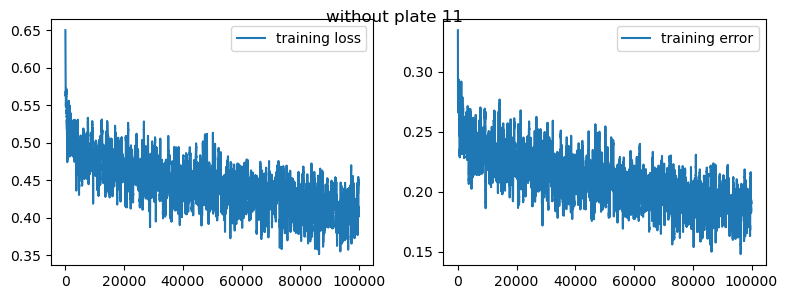

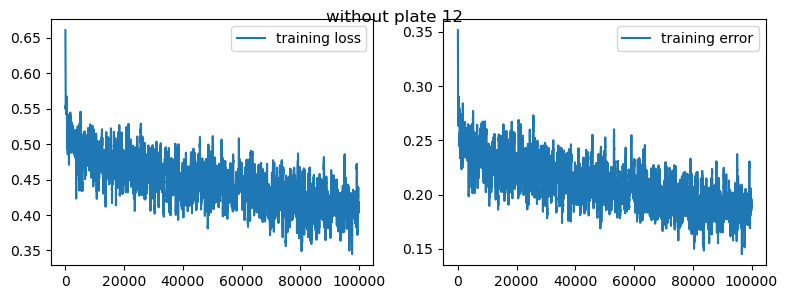

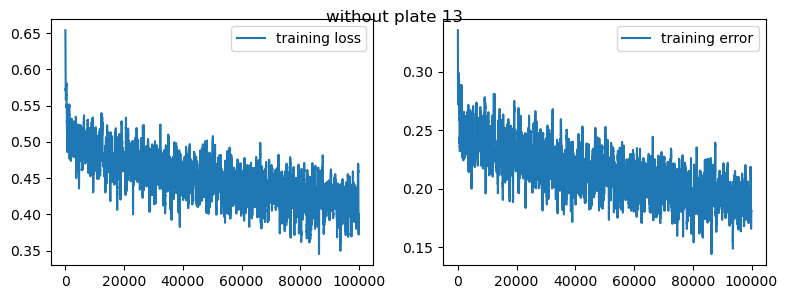

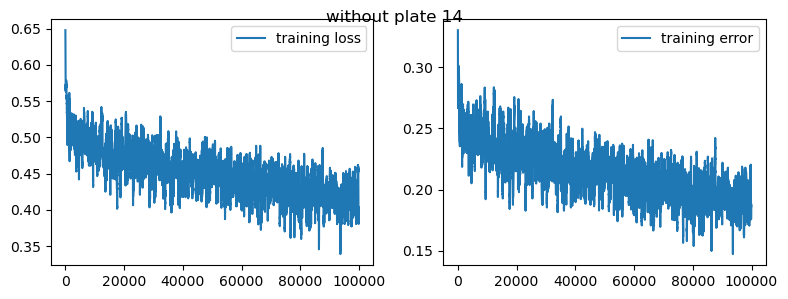

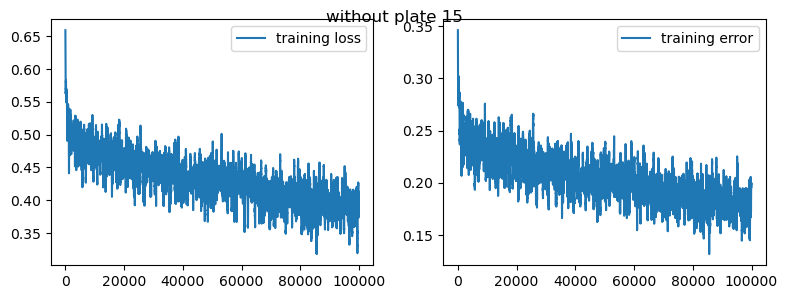

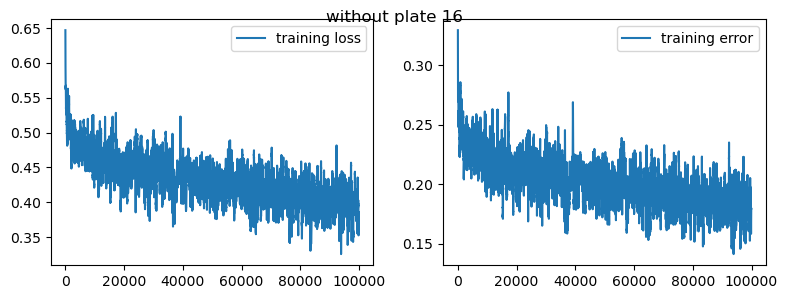

In [18]:
for plate in use_plates:
    name = f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_chrometrics'
    train_loader = healthy_vs_cancer_bagloader(use_plates=use_plates[use_plates != plate].copy())
    model = FeatClassifier(input_dim=182)
    df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.0001, device=device, fname=name, plot=False, 
                     save_model=True, seed=12341)

    w = 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
    ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    fig.suptitle(f'without plate {plate}')
    fig.show()

# file names are wrong in output due to typo (should be 1_16 not 1_17 for plates used)

In [19]:
dfs = []

for plate in tqdm(use_plates):
  df, _, _ = eval_model(f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_chrometrics', 
                        test_healthy_vs_cancer_bagloader(use_plates=[plate]))
  df['plate'] = plate
  dfs.append(df)


res_without_df = pd.concat(dfs, ignore_index=True)
res_without_df

  0%|                                                                                                                                                                                          | 0/16 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


,lab,pred,i,pat,group,plate
0,1,0.0,0,H01,healthy,1
1,1,1.0,0,H01,healthy,1
2,1,0.0,0,H01,healthy,1
3,1,1.0,0,H01,healthy,1
4,1,0.0,0,H01,healthy,1
...,...,...,...,...,...,...
20195,0,0.0,11,P74,cancer,16
20196,0,1.0,11,P74,cancer,16
20197,0,0.0,11,P74,cancer,16
20198,0,0.0,11,P74,cancer,16


In [20]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df

,plate,pat,group,pred,counts
0,1,H01,healthy,0.0,66
1,1,H01,healthy,1.0,34
2,1,H02,healthy,1.0,58
3,1,H02,healthy,0.0,42
4,1,H03,healthy,0.0,83
...,...,...,...,...,...
389,16,P45,cancer,1.0,17
390,16,P61,cancer,1.0,55
391,16,P61,cancer,0.0,45
392,16,P74,cancer,0.0,86


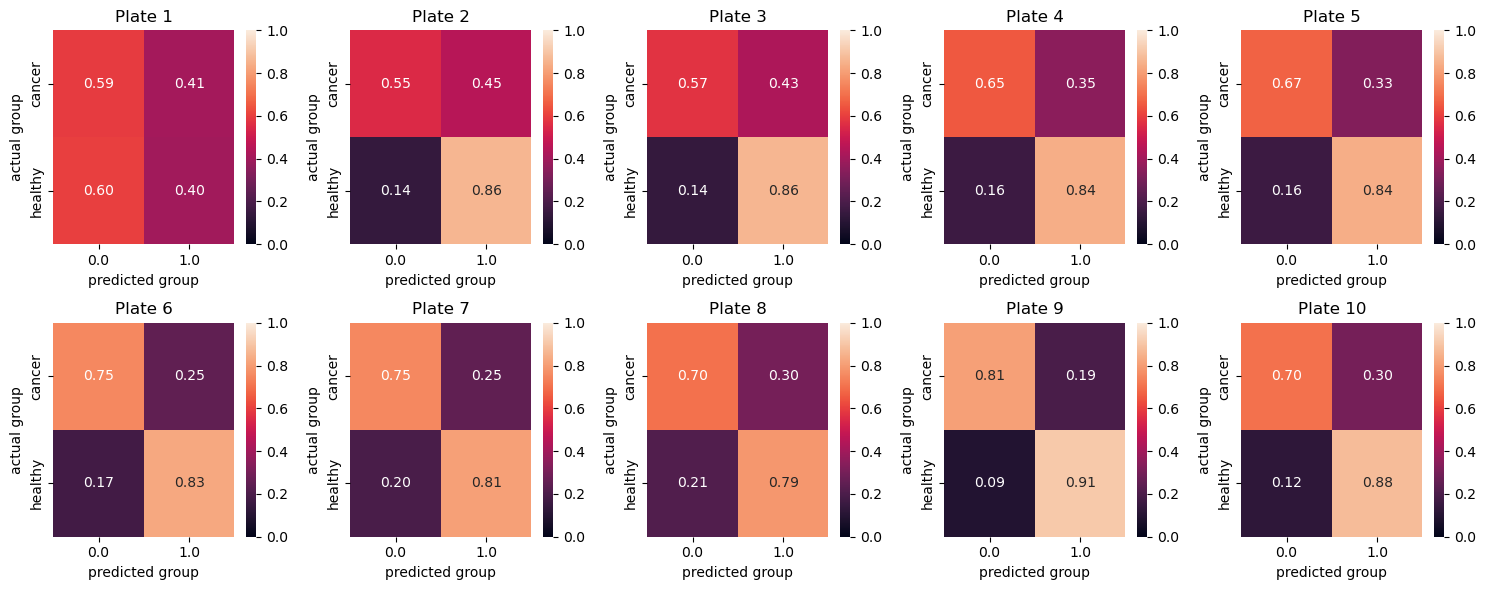

In [21]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

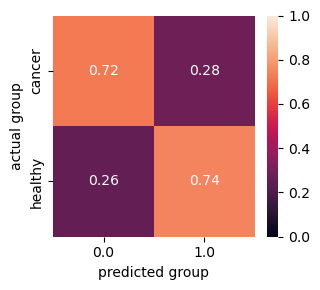

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

In [23]:
res_without_df.groupby(['plate', 'pat', 'group'])['pred'].mean().reset_index()

,plate,pat,group,pred
0,1,H01,healthy,0.34
1,1,H02,healthy,0.58
2,1,H03,healthy,0.17
3,1,H04,healthy,0.46
4,1,H05,healthy,0.45
...,...,...,...,...
197,16,P139,cancer,0.22
198,16,P151,cancer,0.30
199,16,P45,cancer,0.17
200,16,P61,cancer,0.55


In [24]:
pat_df = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].mean().reset_index()
plate_df = pat_df.groupby(['plate', 'group'])['pred'].mean().reset_index()
plate_df.loc[plate_df['group'] != 'healthy', 'group'] = 'C'
plate_df.loc[plate_df['group'] == 'healthy', 'group'] = 'H'
plate_df['group'] = pd.Categorical(values=plate_df['group'], categories=['H', 'C'])
plate_df['H'] = plate_df['pred']
plate_df['C'] = 1 - plate_df['H']

plate_df

,plate,group,pred,H,C
0,1,C,0.410000,0.410000,0.590000
1,1,H,0.400000,0.400000,0.600000
2,2,C,0.450000,0.450000,0.550000
3,2,H,0.860000,0.860000,0.140000
4,3,C,0.427500,0.427500,0.572500
5,3,H,0.862500,0.862500,0.137500
6,4,C,0.350000,0.350000,0.650000
7,4,H,0.840000,0.840000,0.160000
8,5,C,0.331250,0.331250,0.668750
9,5,H,0.840000,0.840000,0.160000


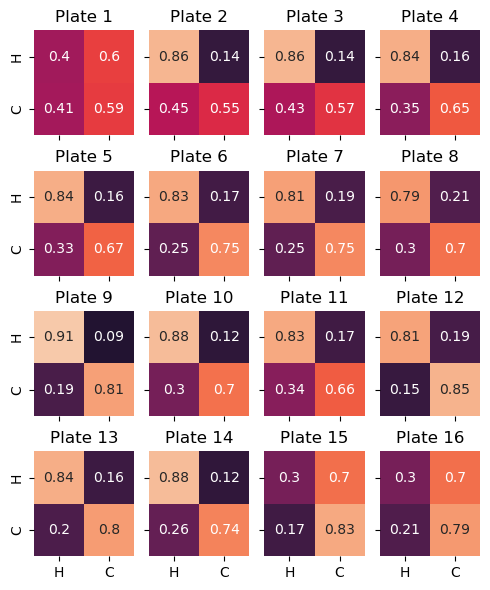

In [25]:
fig, axs = plt.subplots(4, 4, figsize=(5, 6), sharex=True, sharey=True)
for ax, plate in zip(axs.flatten(), use_plates):
    mat = plate_df[plate_df['plate'] == plate].set_index('group').loc[['H', 'C'], ['H', 'C']]
    sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, cbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()